# Lab_4
***Group members:***
- Anastasia Miroshnikova, j41332c
- Pavlovskiy Vladislav, j41325c
- Pasala Krishna Chaitanya, J41332c
- Shan Ali, J41322

**Data set description:**

***City and date indicators***
- city – City abbreviations: sj for San Juan and iq for Iquitos
- week_start_date – Date given in yyyy-mm-dd format

***NOAA's GHCN daily climate data weather station measurements***
- station_max_temp_c – Maximum temperature
- station_min_temp_c – Minimum temperature
- station_avg_temp_c – Average temperature
- station_precip_mm – Total precipitation
- station_diur_temp_rng_c – Diurnal temperature range

***PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)***
- precipitation_amt_mm – Total precipitation

***NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)***
- reanalysis_sat_precip_amt_mm – Total precipitation
- reanalysis_dew_point_temp_k – Mean dew point temperature
- reanalysis_air_temp_k – Mean air temperature
- reanalysis_relative_humidity_percent – Mean relative humidity
- reanalysis_specific_humidity_g_per_kg – Mean specific humidity
- reanalysis_precip_amt_kg_per_m2 – Total precipitation
- reanalysis_max_air_temp_k – Maximum air temperature
- reanalysis_min_air_temp_k – Minimum air temperature
- reanalysis_avg_temp_k – Average air temperature
- reanalysis_tdtr_k – Diurnal temperature range

***Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements***
- ndvi_se – Pixel southeast of city centroid
- ndvi_sw – Pixel southwest of city centroid
- ndvi_ne – Pixel northeast of city centroid
- ndvi_nw – Pixel northwest of city centroid

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import scipy.stats
import seaborn as sns
from statsmodels.tsa import stattools
from scipy import signal
from datetime import datetime
sns.set_style(style = 'darkgrid')

In [2]:
# Loading datasets
data_train = pd.read_csv('dengue_features_train.csv', parse_dates=['week_start_date'])
data_test = pd.read_csv('dengue_labels_train.csv')
data_train['total_cases'] = data_test['total_cases']
data_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


## Step 1: From the dataset 4 variables are selected (3 – target variables).
Obtaining a subsample with timeseries.
Data of city San Juan is only considered.
Feautures considered are: station_avg_temp_c, station_precip_mm
Target variables: reanalysis_relative_humidity_percent , total_cases, ndvi_se.

In [3]:
sj_city = (data_train['city']=='sj')
data_train = data_train[sj_city]
data = data_train[['week_start_date', 'station_avg_temp_c', 'station_precip_mm','reanalysis_relative_humidity_percent',\
                   'ndvi_se', 'total_cases']]
data.head()

,week_start_date,station_avg_temp_c,station_precip_mm,reanalysis_relative_humidity_percent,ndvi_se,total_cases
0,1990-04-30,25.442857,16.0,73.365714,0.198483,4
1,1990-05-07,26.714286,8.6,77.368571,0.162357,5
2,1990-05-14,26.714286,41.4,82.052857,0.157200,4
3,1990-05-21,27.471429,4.0,80.337143,0.227557,3
4,1990-05-28,28.942857,5.8,80.460000,0.251200,6


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   week_start_date                       936 non-null    datetime64[ns]
 1   station_avg_temp_c                    930 non-null    float64       
 2   station_precip_mm                     930 non-null    float64       
 3   reanalysis_relative_humidity_percent  930 non-null    float64       
 4   ndvi_se                               917 non-null    float64       
 5   total_cases                           936 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 51.2 KB


There are nan values, fill the nan values with appropriate values, based on the distribution.

In [5]:
data.fillna(method = 'ffill', inplace = True)


/home/chaitanya/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [6]:
# changes the index value to the week_start_date
data.set_index('week_start_date', inplace = True)

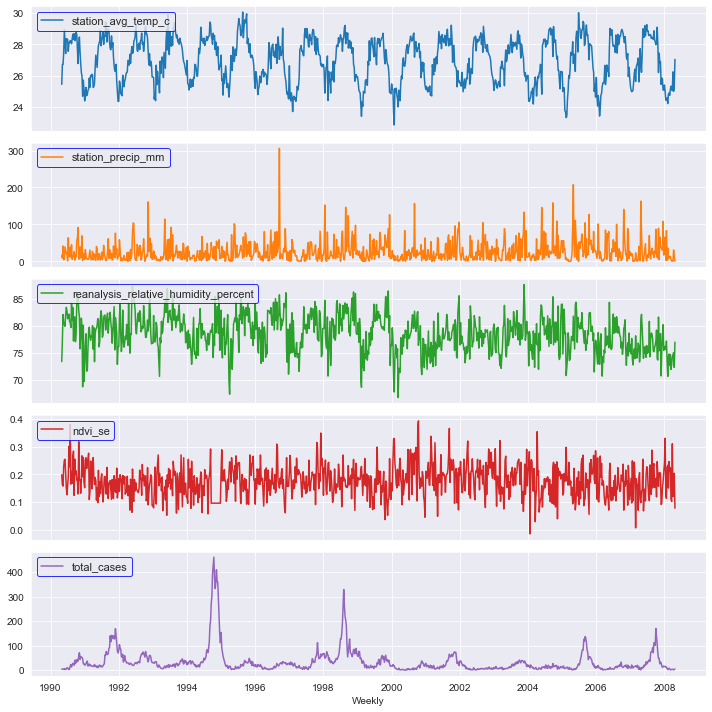

In [7]:
# Plot the choosen target variables.
plot_cols = ['station_avg_temp_c','station_precip_mm','reanalysis_relative_humidity_percent',\
             'ndvi_se', 'total_cases']

fig, axes = plt.subplots(5,1, figsize=(10,10), sharex=True)
data[plot_cols].plot(subplots=True, ax=axes)

# for subplots we must add features by subplot axis
for ax, col in zip(axes, plot_cols):
    
    ax.set_xlabel('Weekly')
    
    # add cool legend
    ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')  

# now to use tight layout
plt.tight_layout()

## Step 2: Analyzing the stationarity of a process (for mathematical expectation and variance) for all chosen variables.

Populating the interactive namespace from numpy and matplotlib


/home/chaitanya/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Augmented Dickey-Fuller test for station_avg_temp_c :
Statistic value = -11.258637
p-value = 0.000000 
No. of lags: 20 


<Figure size 1080x720 with 0 Axes>

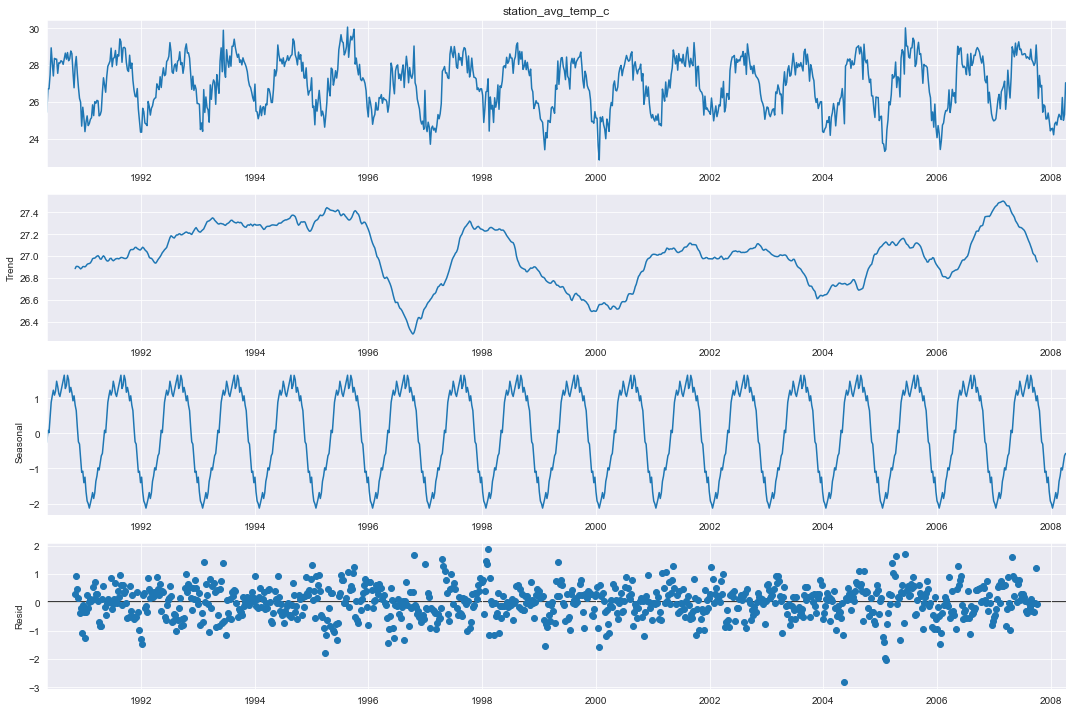

In [8]:
# Decomposing the varibales into trend, sesionality and residual for better analysis
%pylab inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

data.index=pd.date_range(freq="w",start=data.index[0],periods=len(data))
plt.figure(figsize(15,10))
result_station_avg_temp_c = seasonal_decompose((data["station_avg_temp_c"]), model='additive')
result_station_avg_temp_c.plot()

result= smt.stattools.adfuller(data['station_avg_temp_c'])
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d '\
          % ('station_avg_temp_c', result[0], result[1], result[2]))

Augmented Dickey-Fuller test for reanalysis_relative_humidity_percent :
Statistic value = -7.003028
p-value = 0.000000 
No. of lags: 6


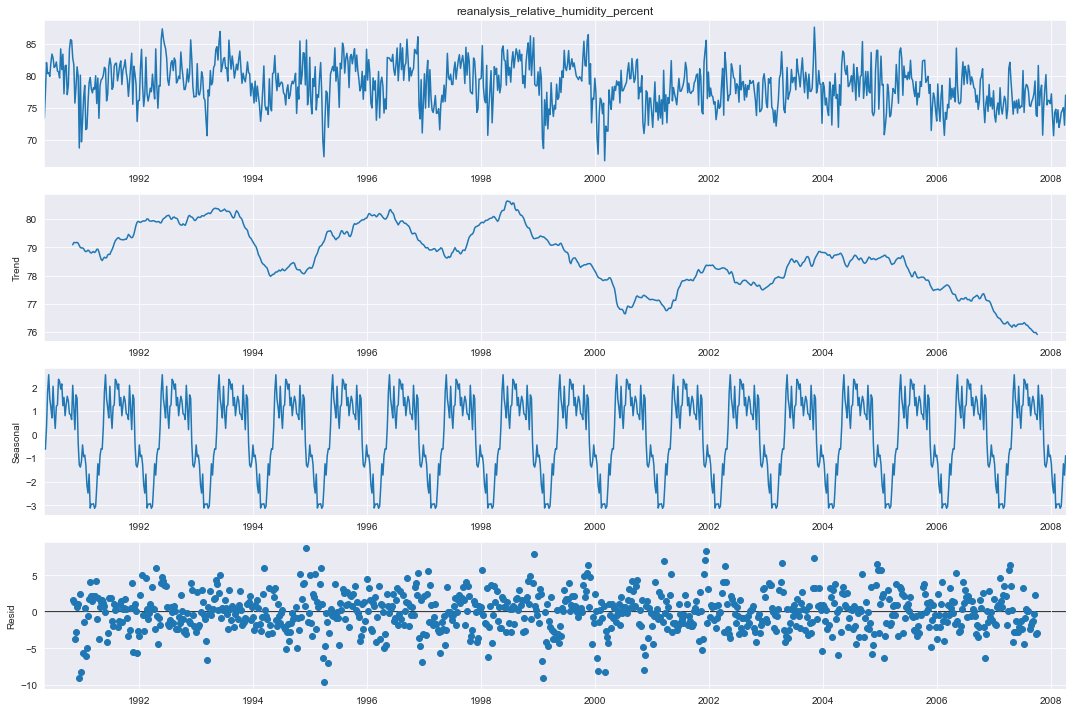

<Figure size 1080x720 with 0 Axes>

In [9]:
# Decomposing the varibales into trend, sesionality and residual for better analysis

result_reanalysis_relative_humidity_percent = seasonal_decompose((data["reanalysis_relative_humidity_percent"]), model='additive')
result_reanalysis_relative_humidity_percent.plot()
plt.figure(figsize(15,10))
result= smt.stattools.adfuller(data['reanalysis_relative_humidity_percent'])
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d'\
          % ('reanalysis_relative_humidity_percent', result[0], result[1], result[2]))

Augmented Dickey-Fuller test for station_precip_mm :
Statistic value = -10.477784
p-value = 0.000000 
No. of lags: 5


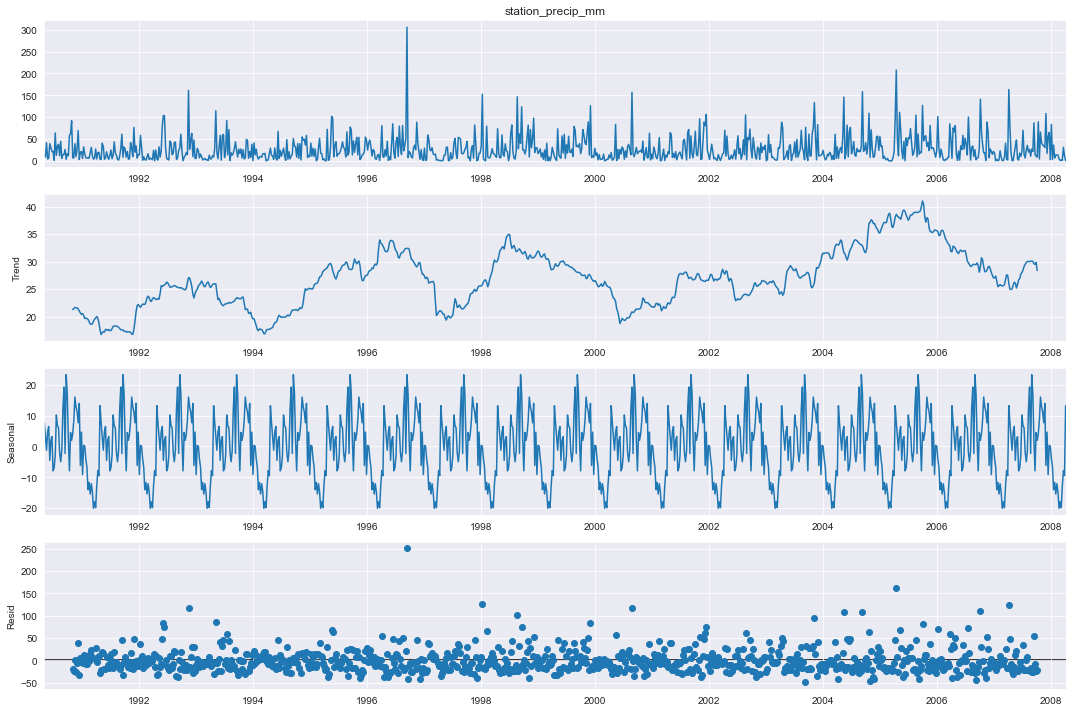

<Figure size 1080x720 with 0 Axes>

In [10]:
# Decomposing the varibales into trend, sesionality and residual for better analysis

result_station_avg_temp_c = seasonal_decompose((data["station_precip_mm"]), model='additive')
result_station_avg_temp_c.plot()
plt.figure(figsize(15,10))
result= smt.stattools.adfuller(data['station_precip_mm'])
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d'\
          % ('station_precip_mm', result[0], result[1], result[2]))

Augmented Dickey-Fuller test for ndvi_se :
Statistic value = -9.514021
p-value = 0.000000 
No. of lags: 5


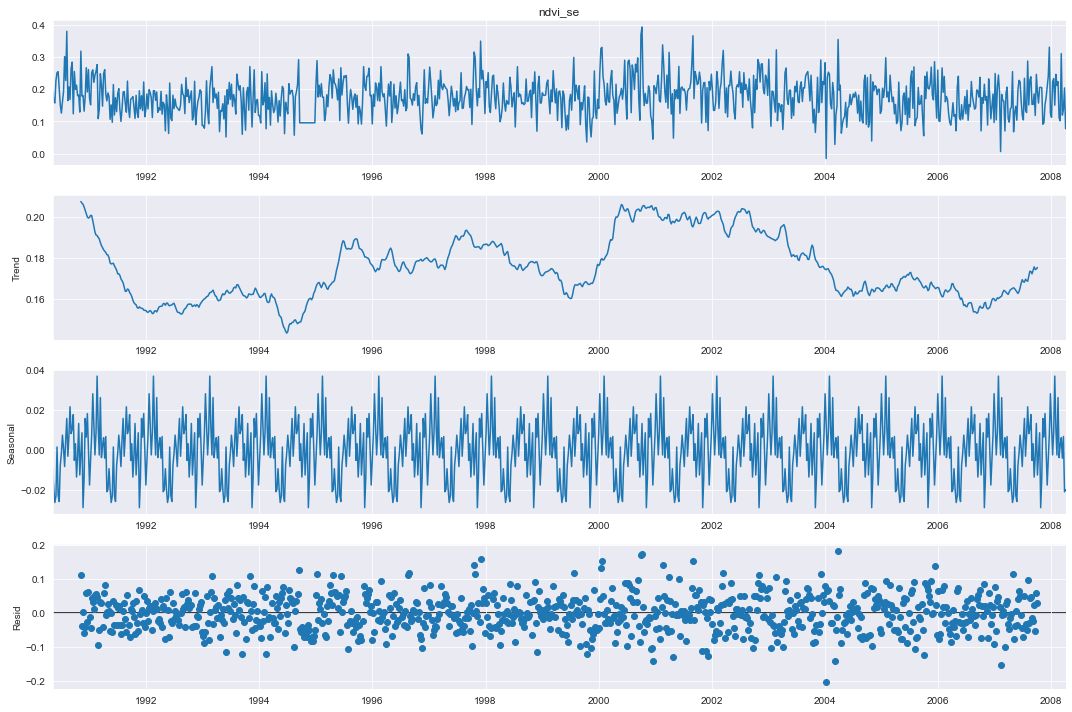

<Figure size 1080x720 with 0 Axes>

In [11]:
# Decomposing the varibales into trend, sesionality and residual for better analysis

result_station_avg_temp_c = seasonal_decompose((data["ndvi_se"]), model='additive')
result_station_avg_temp_c.plot()
plt.figure(figsize(15,10))
result= smt.stattools.adfuller(data['ndvi_se'])
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d'\
          % ('ndvi_se', result[0], result[1], result[2]))

Augmented Dickey-Fuller test for total_cases :
Statistic value = -6.650078
p-value = 0.000000 
No. of lags: 9


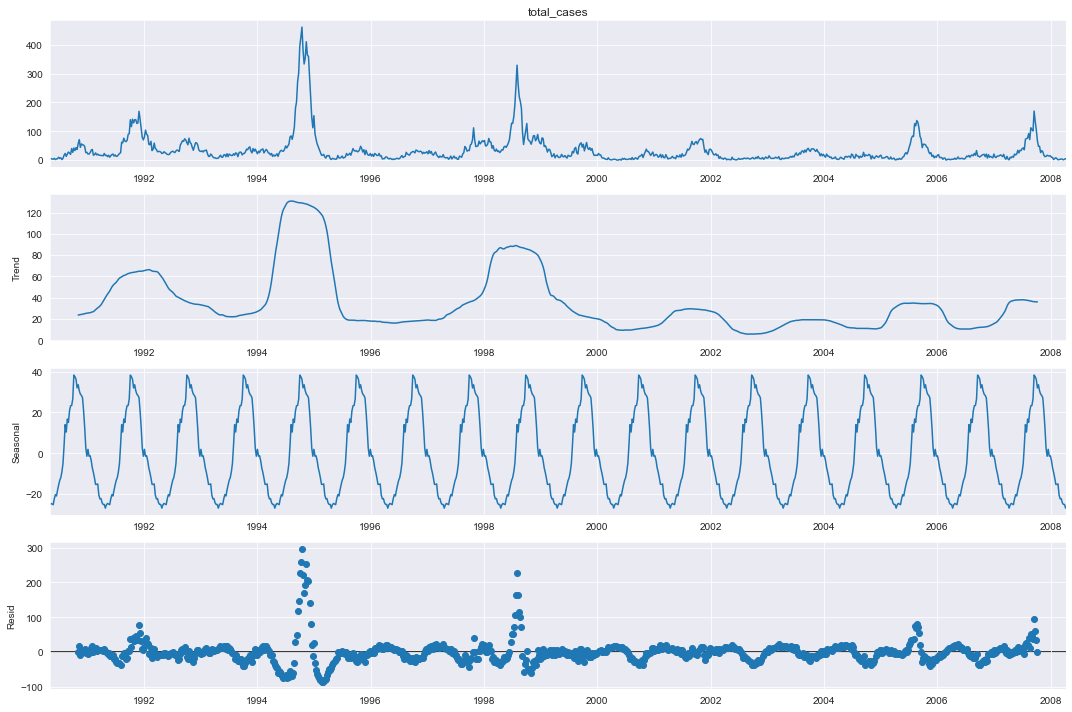

<Figure size 1080x720 with 0 Axes>

In [12]:
# Decomposing the varibales into trend, sesionality and residual for better analysis

result_station_avg_temp_c = seasonal_decompose((data["total_cases"]), model='additive')
result_station_avg_temp_c.plot()
plt.figure(figsize(15,10))
result= smt.stattools.adfuller(data['total_cases'])
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d'\
          % ('total_cases', result[0], result[1], result[2]))

From the results of Dickey-Fuller test, it can be observed that the choosen variable are stationary,

##  Step 3: Analyzing the covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.
***Autocovariance/Autocorrelation:***
- The autocovariance is the covariance of a variable with itself at some other time, measured by a time lag.
- The Autocorrelation function is the normalized autocovariance function.
- Autocorrelation/Autocovariance function is used to estimate the dominant periods in the time series.
- Autocorrelation values are the most obvious way to measure the linearity of that dependence.
- Typically, you'd expect the autocorrelation function to fall towards 0 as points become more separated because its generally harder to forecast further into the future from a given set of data.

***Crosscovariance/Crosscorrelation:***
- Cross-correlation is a measurement that tracks the movements of two or more sets of time series data relative to one another. It is used to compare multiple time series and objectively determine how well they match up with each other and, in particular, at what point the best match occurs.
- Cross-correlation is used to track the similarities in the movement of two factors over time.




Autocorrelation function of reanalysis_relative_humidity_percent


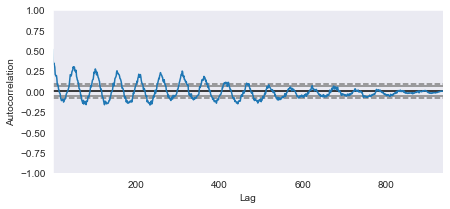

Autocorrelation function of ndvi_se


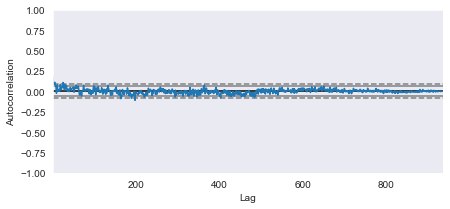

Autocorrelation function of total_cases


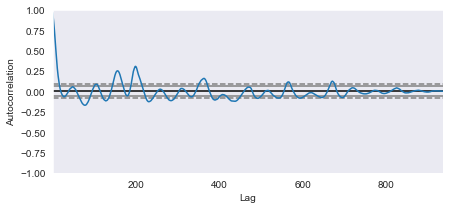

In [13]:
# Plotting autocorrelation function for selected atrget variables
from pandas.plotting import autocorrelation_plot
plot_cols = ['reanalysis_relative_humidity_percent', 'ndvi_se', 'total_cases']
           
for col in plot_cols:
    plt.figure(figsize=(7,3))
    autocorrelation_plot(data[col])
    print('Autocorrelation function of {}'.format(col))
    plt.show()


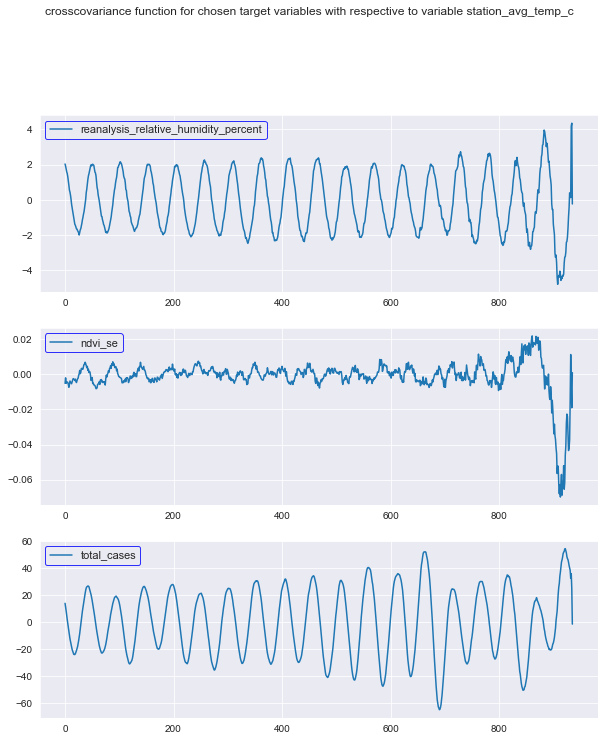

In [14]:
plt.figure(figsize=(10,15))
# for subplots we must add features by subplot axis
for i, col in zip(range(len(plot_cols)), plot_cols):
    
    plt.subplot(4,1,i+1)
    
    plt.plot(stattools.ccovf(data.station_avg_temp_c, data[col]))
    plt.legend((col,), loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue') 

plt.suptitle('crosscovariance function for chosen target variables with respective to variable station_avg_temp_c')
plt.show()

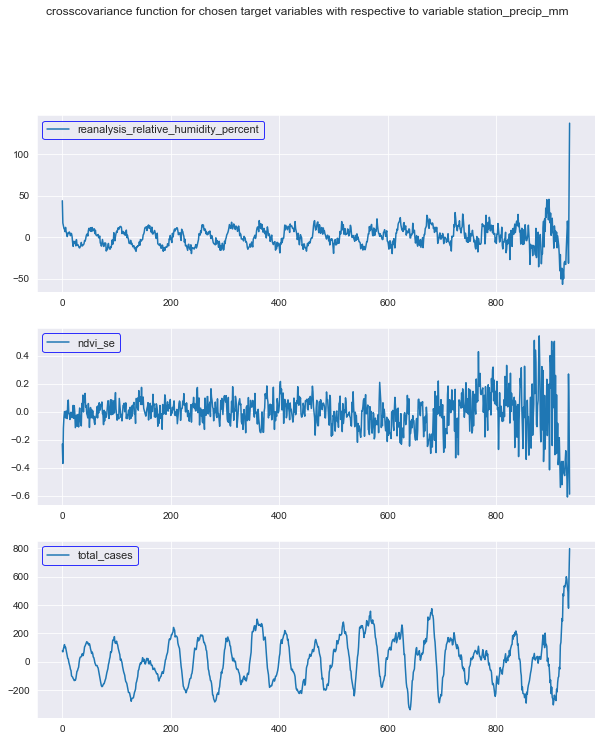

In [15]:
plt.figure(figsize=(10,15))
# for subplots we must add features by subplot axis
for i, col in zip(range(len(plot_cols)), plot_cols):
    
    plt.subplot(4,1,i+1)
    
    plt.plot(stattools.ccovf(data.station_precip_mm, data[col]))
    plt.legend((col,), loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue') 

plt.suptitle('crosscovariance function for chosen target variables with respective to variable station_precip_mm')
plt.show()

##  Step 4: Filter high frequencies (noise) with chosen 2 filters for target variables.
- Time filtering technique is used to remove or to retain variations at particular bands of frequencies from the time series.
- As high frequency noises has to be removed Low pass fileters are used.

***Butterworth Filter***
- The Butterworth filter is a type of signal processing filter designed to have as flat frequency response as possible (no ripples) in the pass-band and zero roll off response in the stop-band.



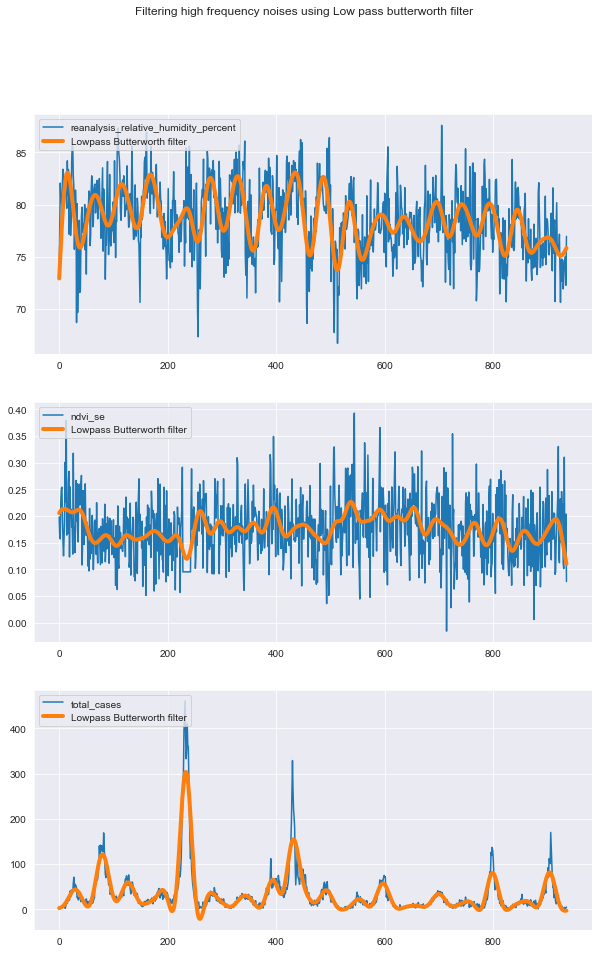

In [16]:
from scipy import signal
data.reset_index(drop=False, inplace=True)
fs = 1000 #sampling frequency
fc = 30  #cut frequency
w = fc / (fs / 2) #normalisation
b, a = signal.butter(5, w, 'low')
plt.figure(figsize=(10, 15))
data_btw_filter = {}
# for subplots we must add features by subplot axis
for i, col in zip(range(len(plot_cols)), plot_cols):
    
    plt.subplot(3,1,i+1)
    
    output_btw = signal.filtfilt(b, a, data[col])
    
    data_btw_filter[col] = output_btw
    plt.plot(data[col].iloc[:], label =col)
    plt.plot(output_btw, linewidth=4, label = 'Lowpass Butterworth filter')
    
    plt.legend(loc='upper left')
    #plt.legend((col,), loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue') 

plt.suptitle('Filtering high frequency noises using Low pass butterworth filter')
#plt.suplegend('Lowpass Butterworth filter')
plt.show()


***Gaussian Filter***
- A gaussian filter is a filter whose impulse response is a Gaussian function (or an approximation to it, since a true Gaussian response is physically unrealizable as it has infinite support).

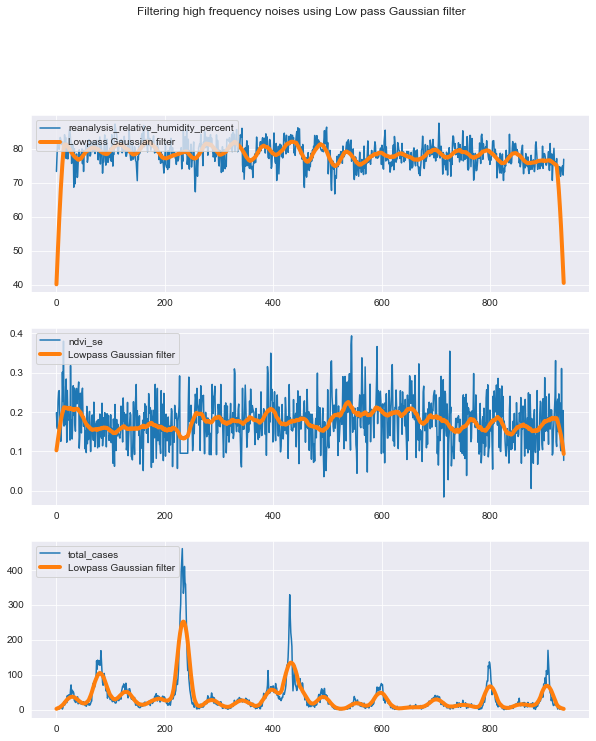

In [17]:
from scipy.ndimage import filters

#gauss filter parameters
windows_size=28
gauss_sd=10
#windows setup
window = signal.gaussian(windows_size, gauss_sd)
data_gaussian_filter = dict()

plt.figure(figsize=(10, 15))

# for subplots we must add features by subplot axis
for i, col in zip(range(len(plot_cols)), plot_cols):
    
    plt.subplot(4,1,i+1)
    
    output_gauss=signal.convolve(data[col], window/window.sum(), mode='same')
    data_gaussian_filter[col] = output_gauss
    plt.plot(data[col], label =col)
    plt.plot(output_gauss, linewidth=4, label = 'Lowpass Gaussian filter')
    
    plt.legend(loc='upper left')
    #plt.legend((col,), loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue') 

plt.suptitle('Filtering high frequency noises using Low pass Gaussian filter')
#plt.suplegend('Lowpass Butterworth filter')
plt.show()




## Step 5: Estimate spectral density function for with and without filtering.
- The spectral density is a frequency domain representation of a time series that is directly related to the autocovariance time domain representation. In essence the spectral density and the autocovariance function contain the same information, but express it in different ways.
- Power spectral density function (PSD) shows the strength of the variations/energies as a function of frequency. In other words, it shows at which frequencies variations are strong and at which frequencies variations are weak.
- PSD is a very useful tool if you want to know frequencies and amplitudes of oscillatory signals in your time series data.

spectral density function for unfiltered data.

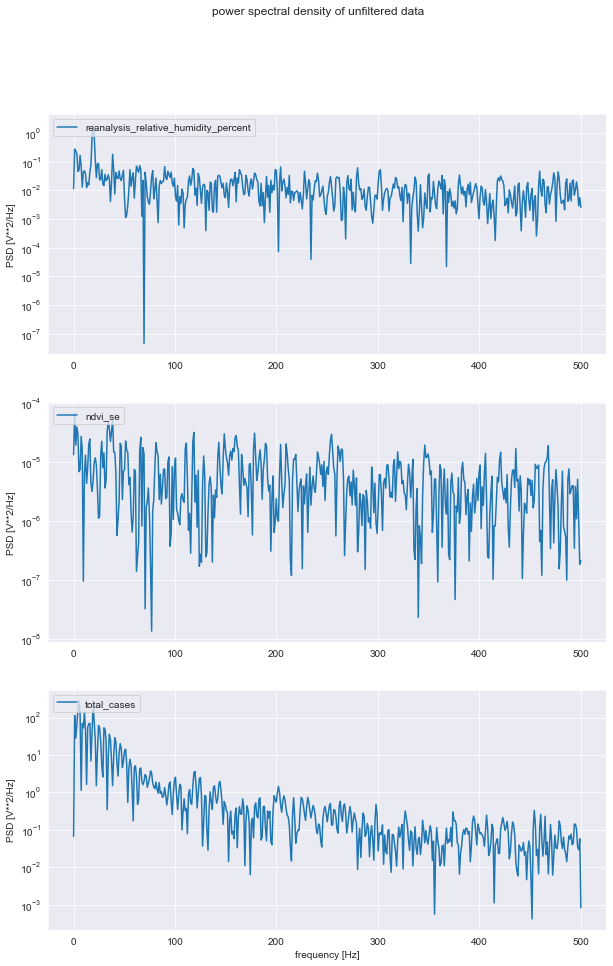

In [19]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 15))

for i, col in zip(range(len(plot_cols)), plot_cols):
    
    plt.subplot(3,1,i+1)
    
    f, Pxx_den = signal.welch(data[col], fs, nperseg=1024, noverlap = 0) #If noverlap is 0, this method is equivalent to Bartlett’s method
    plt.semilogy(f, Pxx_den, label = col)

    plt.ylabel('PSD [V**2/Hz]')
    
    plt.legend(loc='upper left')
    #plt.legend((col,), loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue') 
plt.xlabel('frequency [Hz]')
plt.suptitle('power spectral density of unfiltered data')
plt.show()

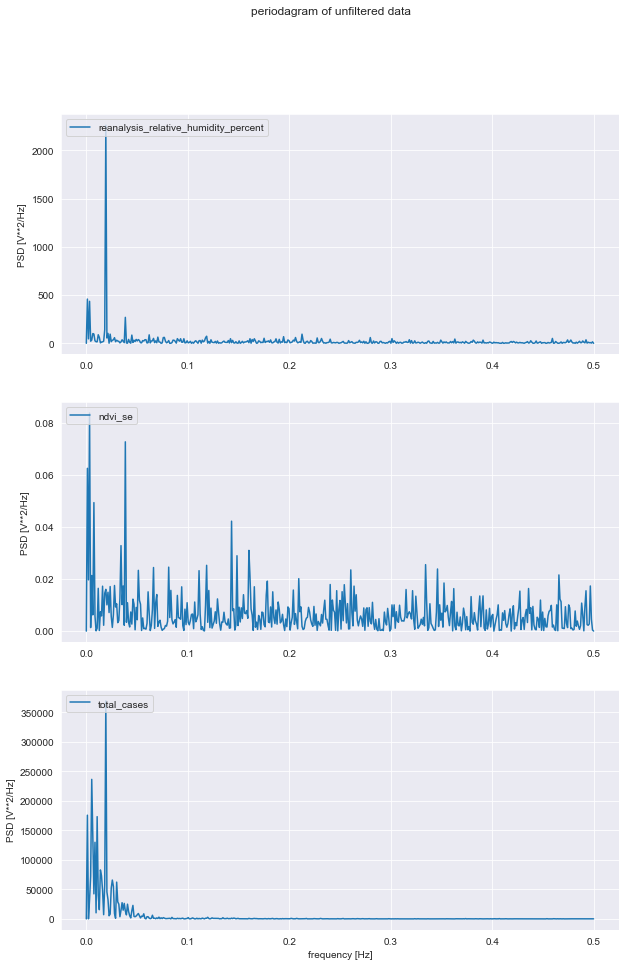

In [20]:

plt.figure(figsize=(10, 15))

for i, col in zip(range(len(plot_cols)), plot_cols):
    
    plt.subplot(3,1,i+1)
    
    f, p = signal.periodogram(x=data[col],fs=1,window=None)
    plt.plot(f,p, label=col)

    plt.ylabel('PSD [V**2/Hz]')
    
    plt.legend(loc='upper left')
    #plt.legend((col,), loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue') 
plt.xlabel('frequency [Hz]')
plt.suptitle('periodagram of unfiltered data')
plt.show()

spectral density function for butterworth filtered data.

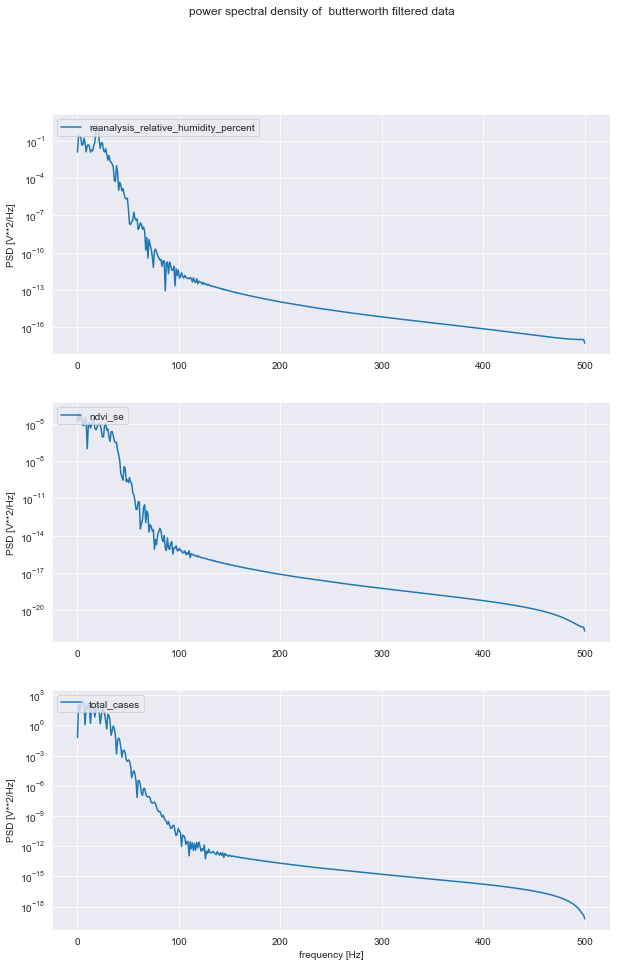

In [21]:
plt.figure(figsize=(10, 15))

for i, col in zip(range(len(plot_cols)), plot_cols):
    
    plt.subplot(3,1,i+1)
    
    f, Pxx_den = signal.welch(data_btw_filter[col], fs, nperseg=1024, noverlap = 0) #If noverlap is 0, this method is equivalent to Bartlett’s method
    plt.semilogy(f, Pxx_den, label = col)

    plt.ylabel('PSD [V**2/Hz]')
    
    plt.legend(loc='upper left')
    
plt.xlabel('frequency [Hz]')
plt.suptitle('power spectral density of  butterworth filtered data')
plt.show()

spectral density function for Gaussian filtered data.

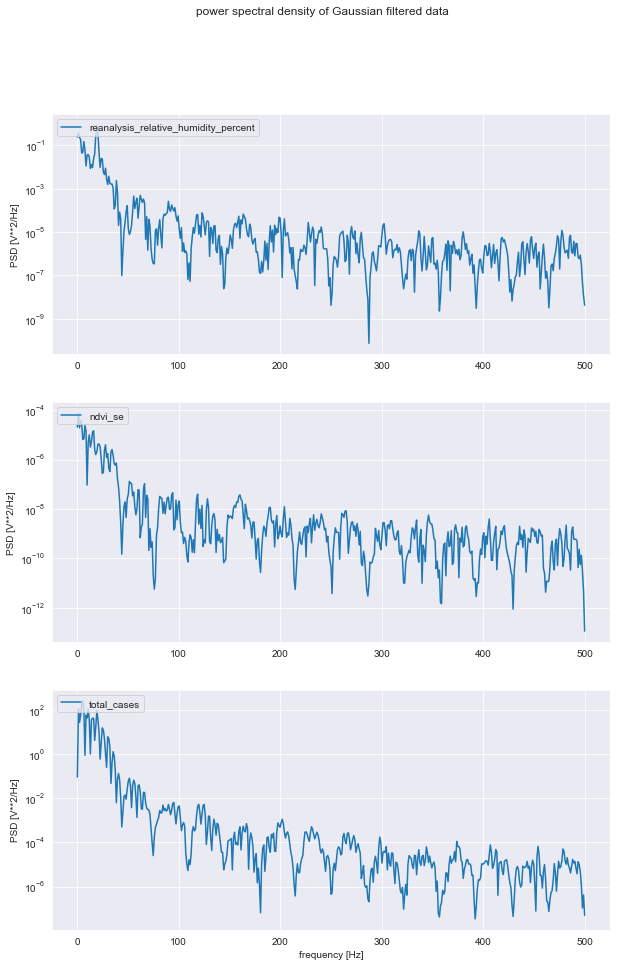

In [22]:

plt.figure(figsize=(10, 15))

for i, col in zip(range(len(plot_cols)), plot_cols):
    
    plt.subplot(3,1,i+1)
    
    f, Pxx_den = signal.welch(data_gaussian_filter[col], fs, nperseg=1024, noverlap = 0) #If noverlap is 0, this method is equivalent to Bartlett’s method
    plt.semilogy(f, Pxx_den, label = col)

    plt.ylabel('PSD [V**2/Hz]')
    
    plt.legend(loc='upper left')
    
plt.xlabel('frequency [Hz]')
plt.suptitle('power spectral density of Gaussian filtered data')
plt.show()

## Step 6. Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model.
- In time series analysis, the partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.


- Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems.


- R2: It is squared correlation coefficient. In linear least squares multiple regression with an estimated intercept term, R2 equals the square of the Pearson correlation coefficient between the observed and modeled (predicted) data values of the dependent variable.


- Identification of an AR(Auto-regression) model is often best done with the PACF.
    - For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
- Identification of an MA(Moving-average) model is often best done with the ACF rather than the PACF.
    - For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.


In [23]:
# Setting the index to timeseries
data.set_index('index', inplace = True)

In [24]:
# Inserting the filtered data to the dataframe.
data.insert(3,'btw_reanalysis_relative_humidity_percent',data_btw_filter['reanalysis_relative_humidity_percent'], True)
data.insert(4, 'btw_ndvi_se', data_btw_filter['ndvi_se'], True)
data.insert(5,'btw_total_cases',data_btw_filter['total_cases'], True)
data.insert(6, 'gau_reanalysis_relative_humidity_percent', data_gaussian_filter['reanalysis_relative_humidity_percent'], True)
data.insert(7, 'gau_ndvi_se', data_gaussian_filter['ndvi_se'], True)
data.insert(8, 'gau_total_cases', data_gaussian_filter['total_cases'], True)

#### Auto regression function for filtered and unfiltered reanalysis_relative_humidity_percent

Populating the interactive namespace from numpy and matplotlib


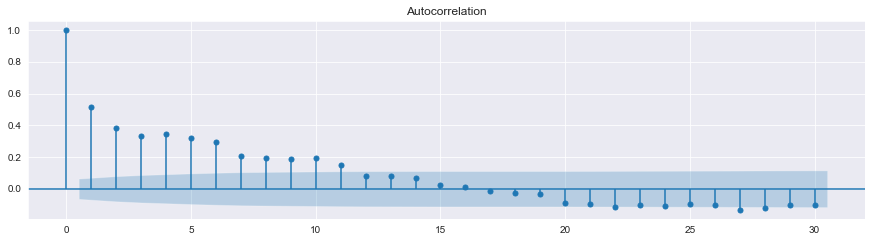

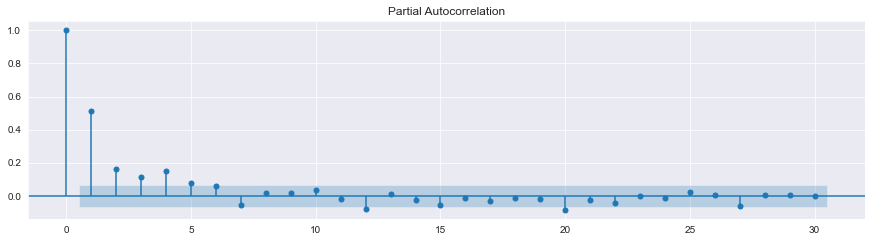

Auto correlation and Partial auto correlation functions of Unfiltered data reanalysis_relative_humidity_percent variable


In [25]:
# Plotiing auto-coorelation and partial corelation functions of the data

%pylab inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['reanalysis_relative_humidity_percent'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['reanalysis_relative_humidity_percent'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of Unfiltered data reanalysis_relative_humidity_percent variable')

###### From the PACF, it can be assumed that with lags of 6, we can predict a appropriate model unfiltered station_avg_temp_c.

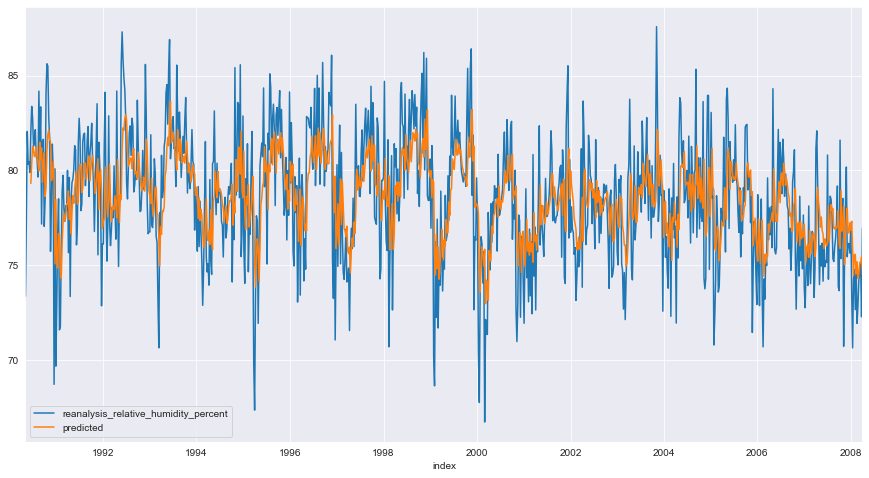

In [26]:
from statsmodels.tsa.ar_model import AutoReg
model_reanalysis_relative_humidity_percent = AutoReg(data['reanalysis_relative_humidity_percent'], lags=6).fit()
pred = dict()
pred['reanalysis_relative_humidity_percent']=model_reanalysis_relative_humidity_percent.predict(start=0, end=len(data)-1,dynamic=False)
data['reanalysis_relative_humidity_percent'].plot(label = 'reanalysis_relative_humidity_percent' )
pred['reanalysis_relative_humidity_percent'].plot(label = 'predicted')
plt.legend()
plt.show()

Populating the interactive namespace from numpy and matplotlib


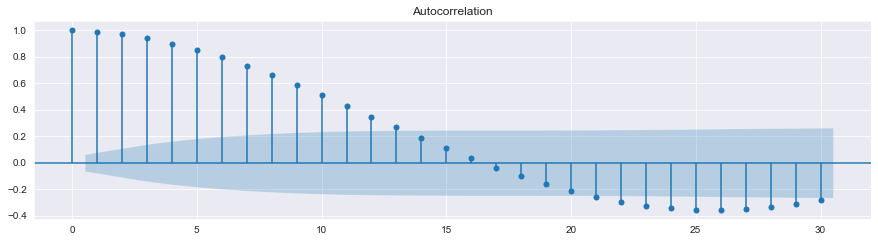

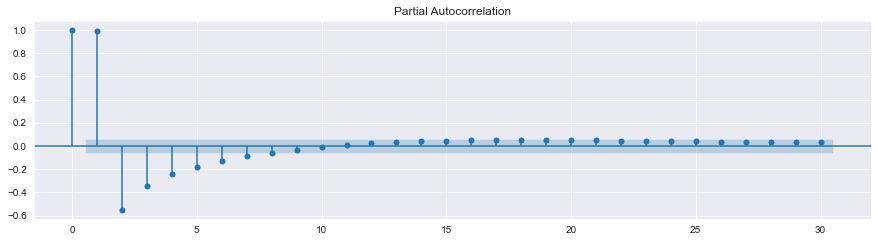

Auto correlation and Partial auto correlation functions of butterworth filtered data reanalysis_relative_humidity_percent variable


In [27]:
%pylab inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['btw_reanalysis_relative_humidity_percent'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['btw_reanalysis_relative_humidity_percent'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of butterworth filtered data reanalysis_relative_humidity_percent variable')

In [78]:
# Getting the order of gaussian filtered reanalysis_relative_humidity_percent data
result= smt.stattools.adfuller(data['gau_reanalysis_relative_humidity_percent'], autolag = 'AIC')
print('Model %s : \n No. of lags: %d'\
          % ('gau_reanalysis_relative_humidity_percent', result[2]))

Model gau_reanalysis_relative_humidity_percent : 
 No. of lags: 8


In [79]:
# Getting the order of Butterworth filtered reanalysis_relative_humidity_percent data
result= smt.stattools.adfuller(data['btw_reanalysis_relative_humidity_percent'], autolag = 'AIC')
print('Model %s :\nNo. of lags: %d'\
          % ('btw_reanalysis_relative_humidity_percent', result[2]))

Model btw_reanalysis_relative_humidity_percent :
No. of lags: 13


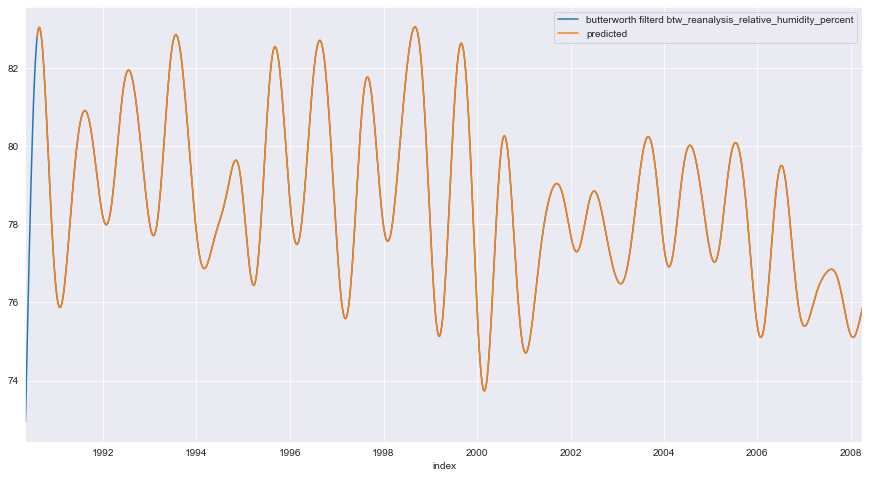

In [30]:
from statsmodels.tsa.ar_model import AutoReg
model_btw_station_precip_mm = AutoReg(data['btw_reanalysis_relative_humidity_percent'], lags=13).fit()
pred['btw_reanalysis_relative_humidity_percent']=model_btw_station_precip_mm.predict(start=0, end=len(data)-1,dynamic=False)
data['btw_reanalysis_relative_humidity_percent'].plot(label = 'butterworth filterd btw_reanalysis_relative_humidity_percent' )
pred['btw_reanalysis_relative_humidity_percent'].plot(label = 'predicted')
plt.legend()
plt.show()

Populating the interactive namespace from numpy and matplotlib


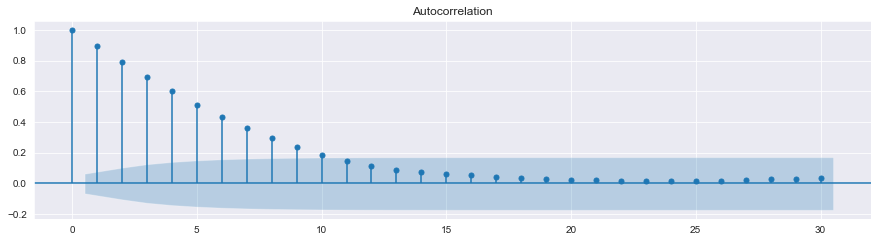

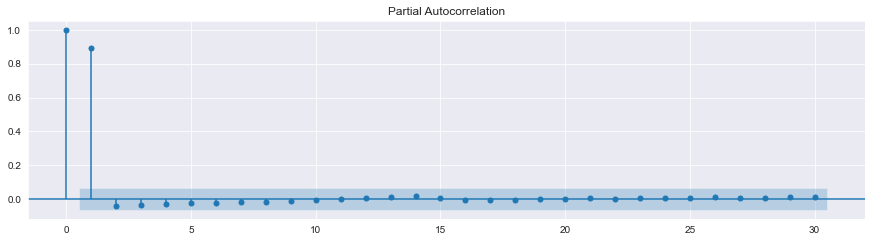

Auto correlation and Partial auto correlation functions of gaussian filtered data gau_reanalysis_relative_humidity_percent variable


In [31]:
%pylab inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['gau_reanalysis_relative_humidity_percent'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['gau_reanalysis_relative_humidity_percent'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of gaussian filtered data gau_reanalysis_relative_humidity_percent variable')

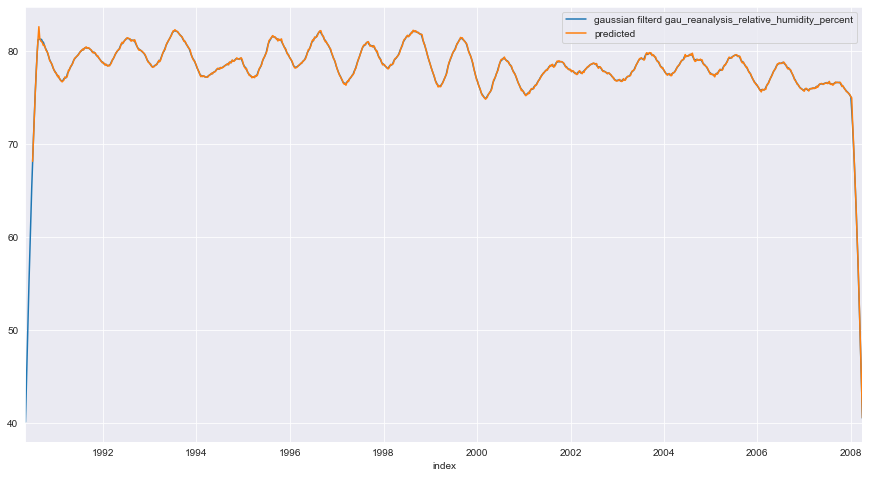

In [32]:
model_gau_station_avg_temp_c = AutoReg(data['gau_reanalysis_relative_humidity_percent'], lags=8).fit()
pred['gau_reanalysis_relative_humidity_percent']=model_gau_station_avg_temp_c.predict(start=0, end=len(data)-1,dynamic=False)
data['gau_reanalysis_relative_humidity_percent'].plot(label = 'gaussian filterd gau_reanalysis_relative_humidity_percent' )
pred['gau_reanalysis_relative_humidity_percent'].plot(label = 'predicted')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
filters = ['reanalysis_relative_humidity_percent', 'gau_reanalysis_relative_humidity_percent', 'btw_reanalysis_relative_humidity_percent']

for fil in filters:
    r2 = r2_score(data[fil][20:], pred[fil][20:])
    mae = mean_absolute_error(data[fil][20:], pred[fil][20:])
    mse = mean_squared_error(data[fil][20:], pred[fil][20:])
    print('model:{} \n R2 score:{} \n mean absolute error(residual error):{} \n mean_squared_error:{} \n '.format(fil, r2, mae, mse))

model:reanalysis_relative_humidity_percent 
 R2 score:0.3137648966973382 
 mean absolute error(residual error):2.1887301961095997 
 mean_squared_error:7.865603305512755 
 
model:gau_reanalysis_relative_humidity_percent 
 R2 score:0.9990398980517083 
 mean absolute error(residual error):0.06785687009768519 
 mean_squared_error:0.00921023821469883 
 
model:btw_reanalysis_relative_humidity_percent 
 R2 score:0.9999976162560729 
 mean absolute error(residual error):0.003205266169837062 
 mean_squared_error:1.0282964531168664e-05 
 


From the above data it is clear that model build using filtered data is better.

#### Auto regression function for filtered and unfiltered ndvi_se

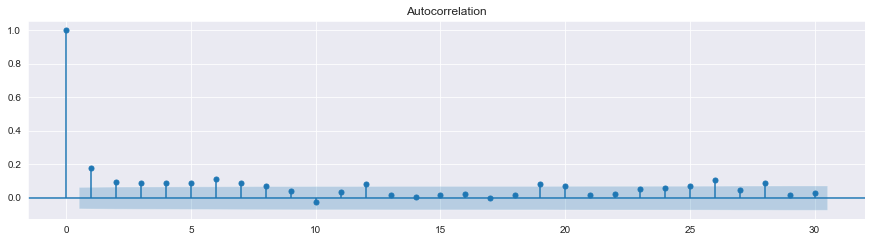

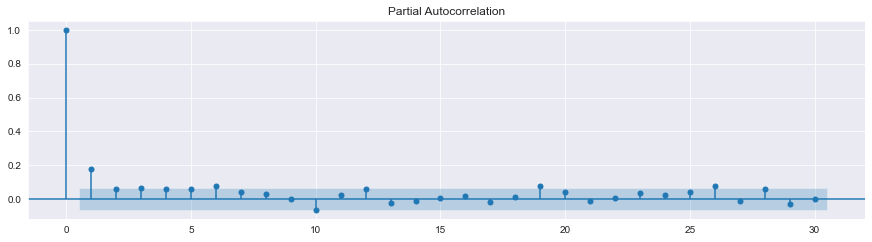

Auto correlation and Partial auto correlation functions of Unfiltered data ndvi_se variable


In [34]:
plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['ndvi_se'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['ndvi_se'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of Unfiltered data ndvi_se variable')

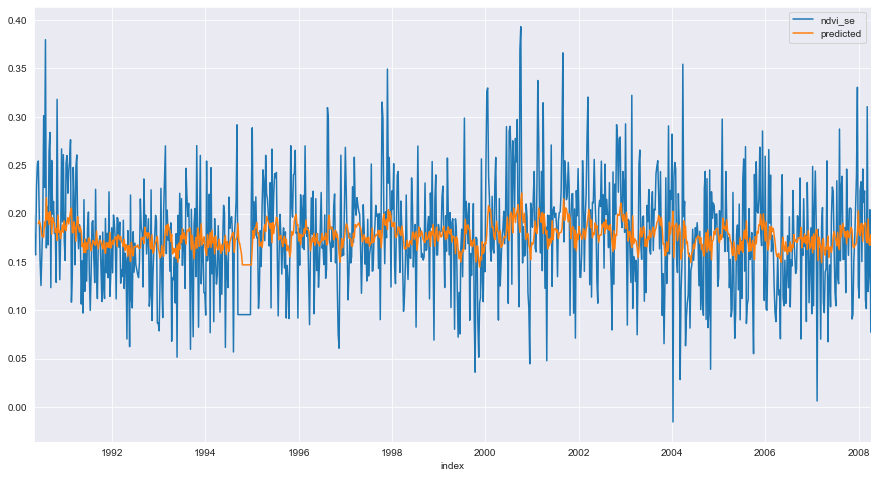

In [35]:
model_gau_ndvi_se = AutoReg(data['ndvi_se'], lags=5).fit()
pred['ndvi_se']=model_gau_ndvi_se.predict(start=0, end=len(data)-1,dynamic=False)
data['ndvi_se'].plot(label = 'ndvi_se' )
pred['ndvi_se'].plot(label = 'predicted')
plt.legend()
plt.show()

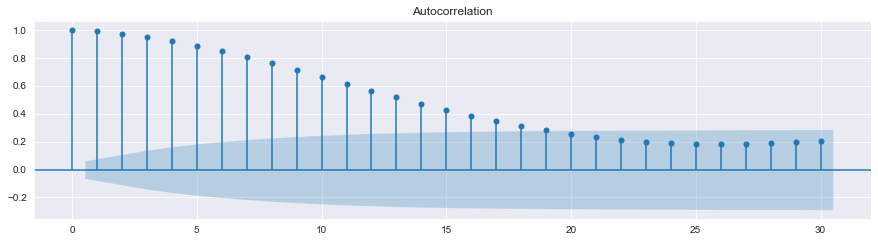

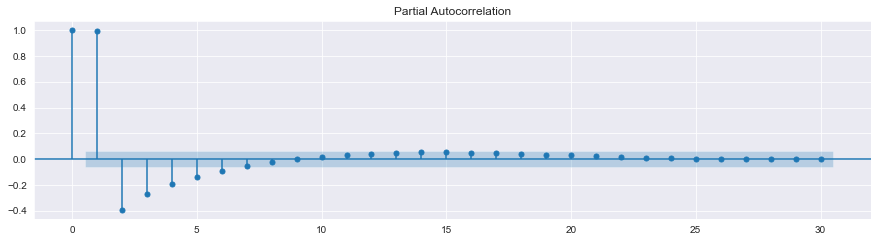

Auto correlation and Partial auto correlation functions of butterworth filtered data ndvi_se variable


In [36]:
plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['btw_ndvi_se'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['btw_ndvi_se'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of butterworth filtered data ndvi_se variable')

In [37]:

result= smt.stattools.adfuller(data['btw_ndvi_se'], autolag = 'AIC')
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d'\
          % ('btw_ndvi_se', result[0], result[1], result[2]))

Augmented Dickey-Fuller test for btw_ndvi_se :
Statistic value = -3.554116
p-value = 0.006701 
No. of lags: 11


In [38]:


result= smt.stattools.adfuller(data['gau_ndvi_se'], autolag = 'AIC')
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d'\
          % ('gau_ndvi_se', result[0], result[1], result[2]))

Augmented Dickey-Fuller test for gau_ndvi_se :
Statistic value = -2.239367
p-value = 0.192269 
No. of lags: 14


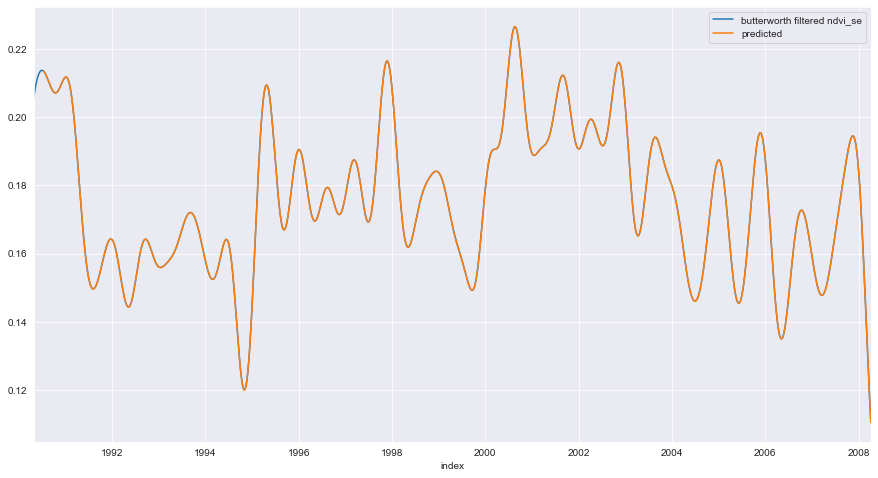

In [39]:
model_gau_ndvi_se = AutoReg(data['btw_ndvi_se'], lags=11).fit()
pred['btw_ndvi_se']=model_gau_ndvi_se.predict(start=0, end=len(data)-1,dynamic=False)
data['btw_ndvi_se'].plot(label = 'butterworth filtered ndvi_se' )
pred['btw_ndvi_se'].plot(label = 'predicted')
plt.legend()
plt.show()

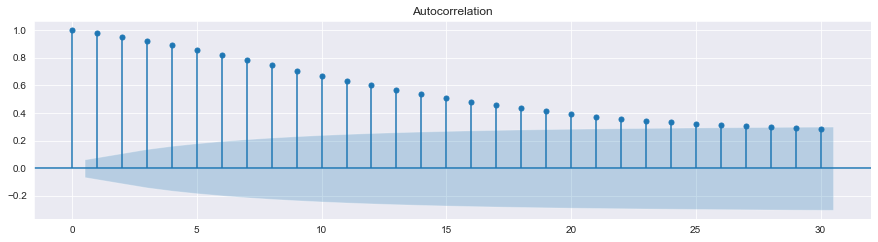

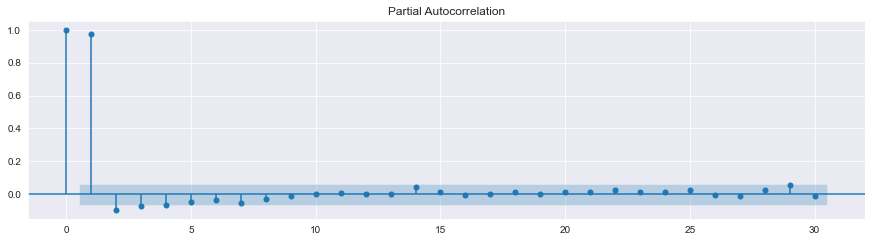

Auto correlation and Partial auto correlation functions of gaussian filtered data ndvi_se variable


In [40]:
plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['gau_ndvi_se'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['gau_ndvi_se'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of gaussian filtered data ndvi_se variable')

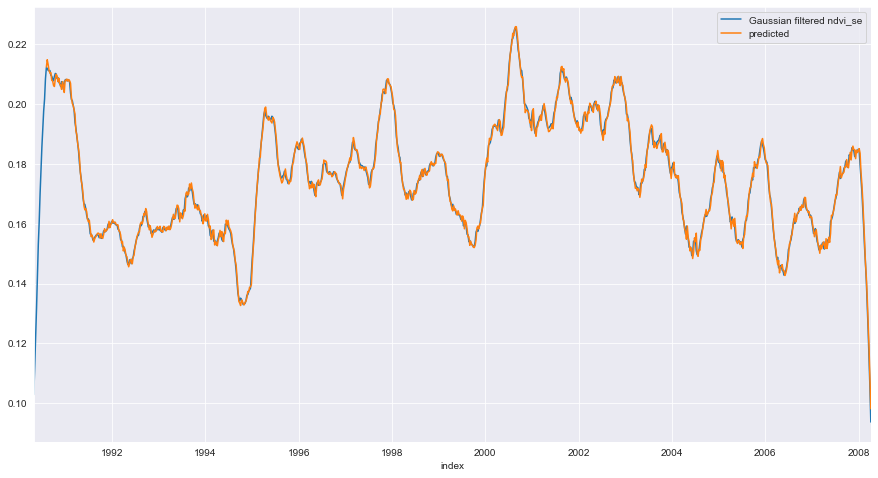

In [41]:
model_gau_ndvi_se = AutoReg(data['gau_ndvi_se'], lags=14).fit()
pred['gau_ndvi_se']=model_gau_ndvi_se.predict(start=0, end=len(data)-1,dynamic=False)
data['gau_ndvi_se'].plot(label = 'Gaussian filtered ndvi_se' )
pred['gau_ndvi_se'].plot(label = 'predicted')
plt.legend()
plt.show()

In [42]:
filters_ndvi_se = ['ndvi_se', 'gau_ndvi_se', 'btw_ndvi_se']

for fil in filters_ndvi_se:
    r2 = r2_score(data[fil][20:], pred[fil][20:])
    mae = mean_absolute_error(data[fil][20:], pred[fil][20:])
    mse = mean_squared_error(data[fil][20:], pred[fil][20:])
    print('model:{} \n R2 score:{} \n mean absolute error(residual error):{} \n mean_squared_error:{} \n '.format(fil, r2, mae, mse))


model:ndvi_se 
 R2 score:0.04468943373308698 
 mean absolute error(residual error):0.04417637190540067 
 mean_squared_error:0.0031259949819149656 
 
model:gau_ndvi_se 
 R2 score:0.9939288305184932 
 mean absolute error(residual error):0.0011672584107398141 
 mean_squared_error:2.1744411525709905e-06 
 
model:btw_ndvi_se 
 R2 score:0.99999999999506 
 mean absolute error(residual error):4.59279860007794e-08 
 mean_squared_error:2.182480867148742e-15 
 


#### Auto regression function for filtered and unfiltrered data of total_cases

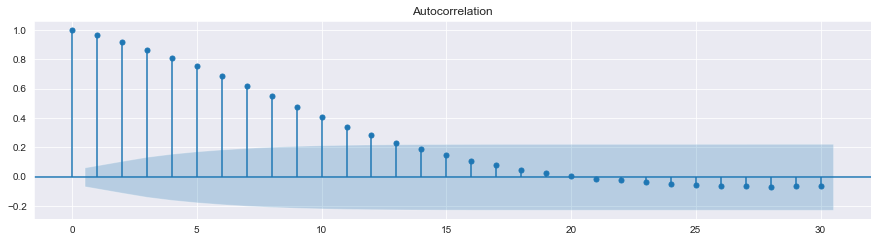

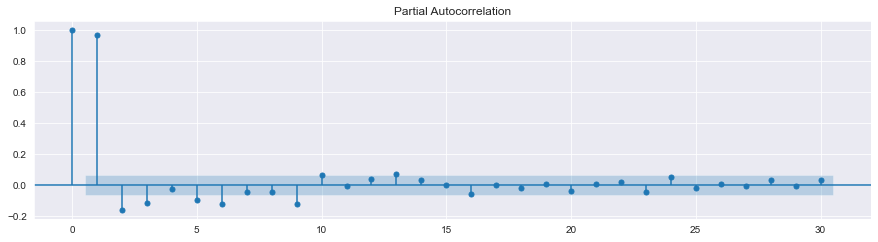

Auto correlation and Partial auto correlation functions of Unfiltered data total_cases variable


In [43]:
plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['total_cases'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['total_cases'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of Unfiltered data total_cases variable')

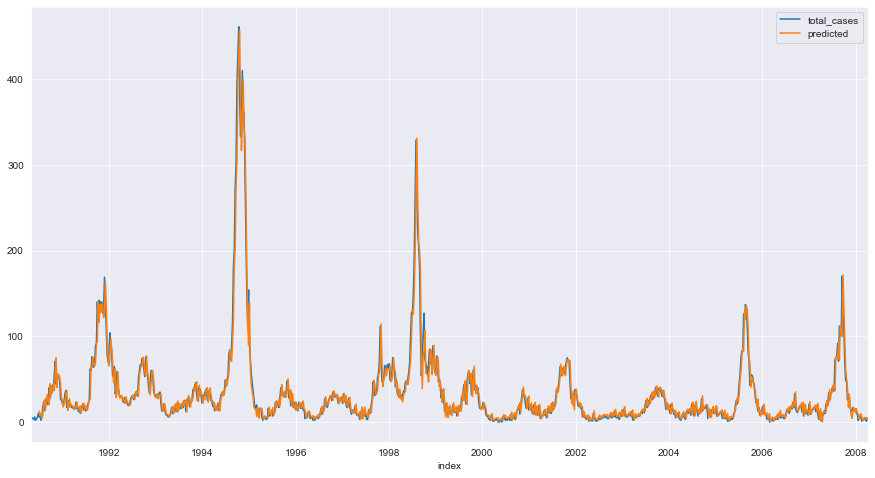

In [44]:
model_gau_ndvi_se = AutoReg(data['total_cases'], lags=9).fit()
pred['total_cases']=model_gau_ndvi_se.predict(start=0, end=len(data)-1,dynamic=False)
data['total_cases'].plot(label = 'total_cases' )
pred['total_cases'].plot(label = 'predicted')
plt.legend()
plt.show()

In [45]:


result= smt.stattools.adfuller(data['btw_total_cases'], autolag = 'AIC')
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d'\
          % ('btw_total_cases', result[0], result[1], result[2]))

Augmented Dickey-Fuller test for btw_total_cases :
Statistic value = -0.897411
p-value = 0.788824 
No. of lags: 10


In [46]:


result= smt.stattools.adfuller(data['gau_total_cases'], autolag = 'AIC')
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d'\
          % ('gau_total_cases', result[0], result[1], result[2]))

Augmented Dickey-Fuller test for gau_total_cases :
Statistic value = -4.048530
p-value = 0.001177 
No. of lags: 21


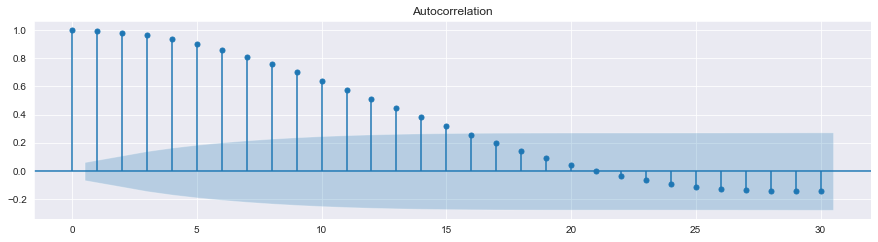

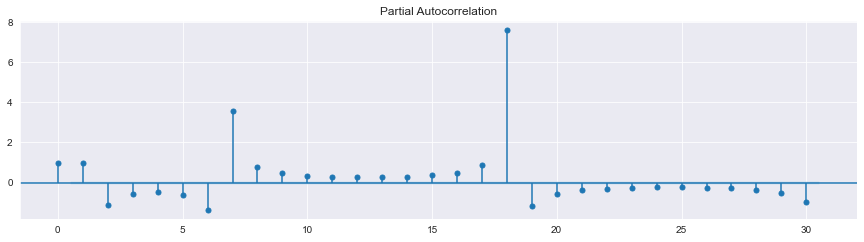

Auto correlation and Partial auto correlation functions of butter worth filtered data total_cases variable


In [47]:
plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['btw_total_cases'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['btw_total_cases'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of butter worth filtered data total_cases variable')

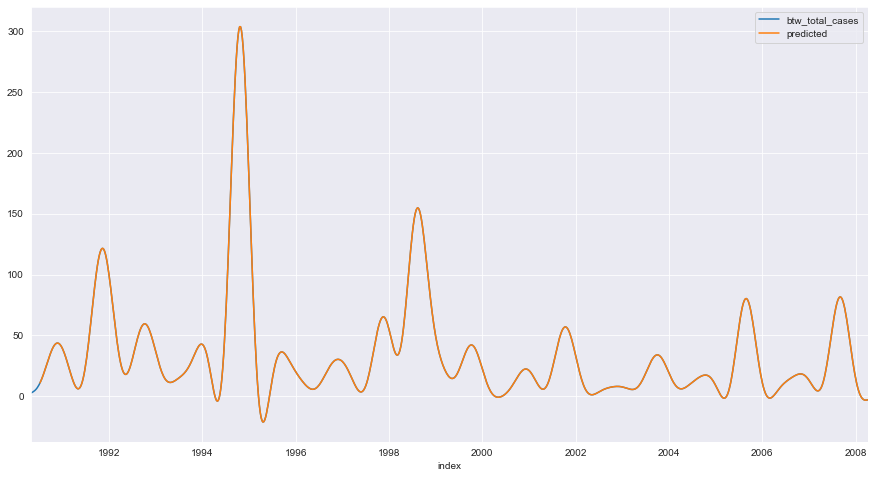

In [48]:
model_btw_total_cases = AutoReg(data['btw_total_cases'], lags=10).fit()
pred['btw_total_cases']=model_btw_total_cases.predict(start=0, end=len(data)-1,dynamic=False)
data['btw_total_cases'].plot(label = 'btw_total_cases' )
pred['btw_total_cases'].plot(label = 'predicted')
plt.legend()
plt.show()

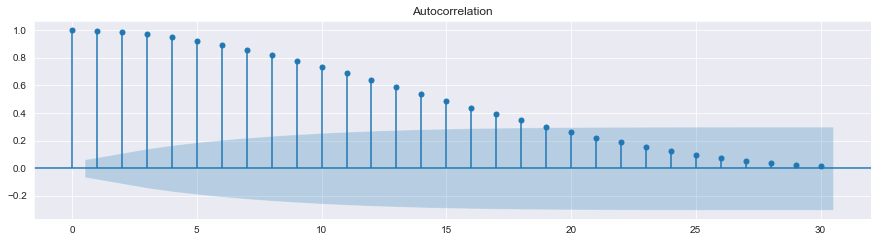

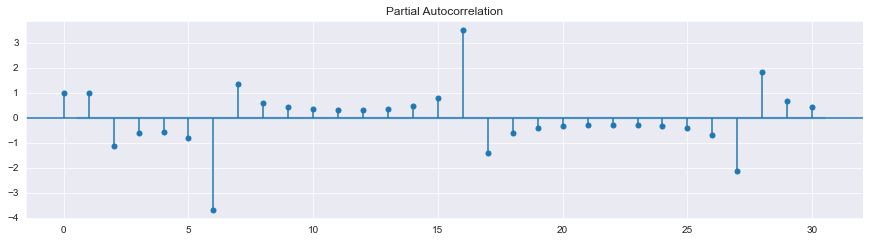

Auto correlation and Partial auto correlation functions of gaussian filtered data total_cases variable


In [49]:
plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['gau_total_cases'].values.squeeze(), ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['gau_total_cases'].values.squeeze(), ax=ax)
pylab.show()
print('Auto correlation and Partial auto correlation functions of gaussian filtered data total_cases variable')

From the PACF, it can be assumed that with lags of 1, we can predict a appropriate model for gaussian filtered total_cases.

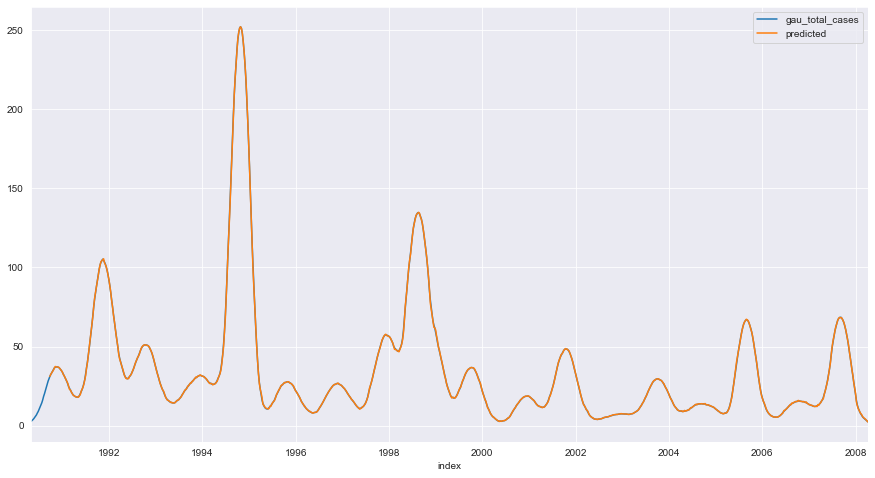

In [50]:
model_gau_total_cases = AutoReg(data['gau_total_cases'], lags=21).fit()
pred['gau_total_cases']=model_gau_total_cases.predict(start=0, end=len(data)-1,dynamic=False)
data['gau_total_cases'].plot(label = 'gau_total_cases' )
pred['gau_total_cases'].plot(label = 'predicted')
plt.legend()
plt.show()

In [51]:
filters_total_cases = ['total_cases', 'gau_total_cases', 'btw_total_cases']

for fil in filters_total_cases:
    r2 = r2_score(data[fil][25:], pred[fil][25:])
    mae = mean_absolute_error(data[fil][25:], pred[fil][25:])
    mse = mean_squared_error(data[fil][25:], pred[fil][25:])
    print('model:{} \n R2 score:{} \n mean absolute error(residual error):{} \n mean_squared_error:{} \n '.format(fil, r2, mae, mse))



model:total_cases 
 R2 score:0.936480177488086 
 mean absolute error(residual error):8.013512935903174 
 mean_squared_error:171.20850940210283 
 
model:gau_total_cases 
 R2 score:0.9999241829476706 
 mean absolute error(residual error):0.22574345452797157 
 mean_squared_error:0.11518561614904071 
 
model:btw_total_cases 
 R2 score:0.9999999999999972 
 mean absolute error(residual error):1.4511243462802756e-06 
 mean_squared_error:5.931873291057362e-12 
 


### From the above statistical information it is clear that the model build using filtered data is better.

## Step 7. Build model in a form of linear dynamical system, using chosen predictors. To analyze residual error and to define appropriate order of model. 
***Linear dynamical systems***
- Linear dynamical systems are dynamical systems whose evaluation functions are linear.
- Dynamic linear models (DLM) offer a very generic framework to analyse time series data. The models can be seen as general regression models where the coefficients can vary in time.


### Building a linear dynamic model for data total_cases

In [52]:
# creating a dataframe to build linear dynamic model for total_cases
data_total_cases = data[['total_cases','station_avg_temp_c','station_precip_mm']]
data_total_cases.head()

,total_cases,station_avg_temp_c,station_precip_mm
index,,,
1990-05-06,4,25.442857,16.0
1990-05-13,5,26.714286,8.6
1990-05-20,4,26.714286,41.4
1990-05-27,3,27.471429,4.0
1990-06-03,6,28.942857,5.8


In [53]:
# Finding the order of the model, where the AIC score is lowest.
from statsmodels.tsa.api import VAR
model = VAR(data_total_cases, freq="1W")
model.select_order(20).summary()


,AIC,BIC,FPE,HQIC
0,15.32,15.34,4.505e+06,15.33
1,10.98,11.04,5.869e+04,11.00
2,10.88,10.99*,5.323e+04,10.92
3,10.86,11.02,5.227e+04,10.92*
4,10.87,11.07,5.245e+04,10.95
5,10.87,11.12,5.256e+04,10.97
6,10.86,11.16,5.207e+04,10.97
7,10.85,11.19,5.133e+04,10.98
8,10.84,11.23,5.093e+04,10.99
9,10.83,11.28,5.068e+04,11.00


From the above table it, is clear that AIC values is least for 11 lags. Therefore the order of the model is 11.

In [54]:
results = model.fit(11)
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, Apr, 2021
Time:                     20:46:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.3346
Nobs:                     925.000    HQIC:                   11.0052
Log likelihood:          -8831.48    FPE:                    49124.1
AIC:                      10.8020    Det(Omega_mle):         44082.2
--------------------------------------------------------------------
Results for equation total_cases
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                        -29.984884        11.895571           -2.521           0.012
L1.total_cases                 1.066908         0.033559           31.792           0.000
L1.station_avg_tem

In [55]:
# function to create a dataframe with shifted values.
def lag_df(df, lag, n):
    columns = df.columns
    for i in range(1,lag+1):
        for j in range(n):
            df[columns[j]+'_shift_'+str(i)] = df[columns[j]].shift(i)
            
    return df

In [56]:
df_total_cases_full = lag_df(data_total_cases, 11, 3)
df_total_cases_full.dropna(inplace = True)
df_total_cases_full.head()

,total_cases,station_avg_temp_c,station_precip_mm,total_cases_shift_1,station_avg_temp_c_shift_1,station_precip_mm_shift_1,total_cases_shift_2,station_avg_temp_c_shift_2,station_precip_mm_shift_2,total_cases_shift_3,...,station_precip_mm_shift_8,total_cases_shift_9,station_avg_temp_c_shift_9,station_precip_mm_shift_9,total_cases_shift_10,station_avg_temp_c_shift_10,station_precip_mm_shift_10,total_cases_shift_11,station_avg_temp_c_shift_11,station_precip_mm_shift_11
index,,,,,,,,,,,,,,,,,,,,,
1990-07-22,2,28.128571,12.2,8.0,27.557143,63.7,6.0,28.328571,1.1,10.0,...,4.0,4.0,26.714286,41.4,5.0,26.714286,8.6,4.0,25.442857,16.0
1990-07-29,6,28.114286,32.6,2.0,28.128571,12.2,8.0,27.557143,63.7,6.0,...,5.8,3.0,27.471429,4.0,4.0,26.714286,41.4,5.0,26.714286,8.6
1990-08-05,17,28.242857,37.6,6.0,28.114286,32.6,2.0,28.128571,12.2,8.0,...,39.1,6.0,28.942857,5.8,3.0,27.471429,4.0,4.0,26.714286,41.4
1990-08-12,23,28.200000,11.4,17.0,28.242857,37.6,6.0,28.114286,32.6,2.0,...,29.7,2.0,28.114286,39.1,6.0,28.942857,5.8,3.0,27.471429,4.0
1990-08-19,13,28.042857,44.7,23.0,28.200000,11.4,17.0,28.242857,37.6,6.0,...,21.1,4.0,27.414286,29.7,2.0,28.114286,39.1,6.0,28.942857,5.8


In [57]:
total_cases_lags = np.dot(df_total_cases_full.drop(['total_cases', 'station_avg_temp_c', 'station_precip_mm'], axis = 1 ).values,\
       results.params['total_cases'][1:].values ) + results.params['total_cases'][0]

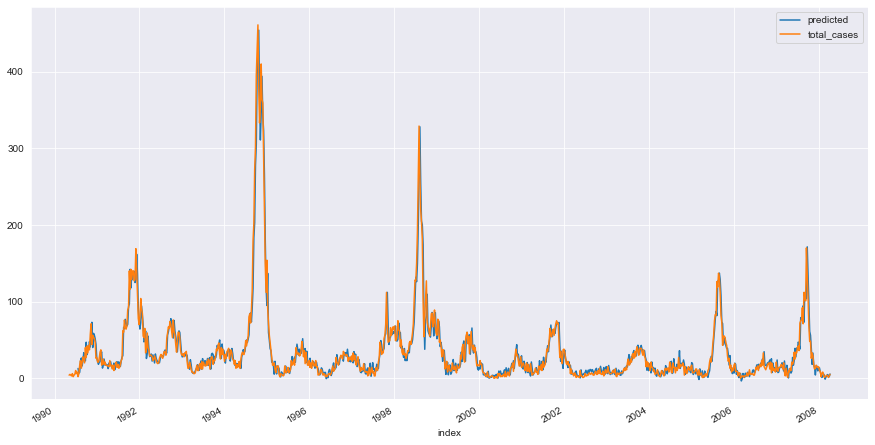

In [58]:
plt.plot(data.index[11:], total_cases_lags, label= 'predicted')
data['total_cases'].plot(label= 'total_cases')
plt.legend()
plt.show()

In [59]:
r2 = r2_score(data['total_cases'][11:], total_cases_lags)
mae = mean_absolute_error(data['total_cases'][11:],total_cases_lags)
mse = mean_squared_error(data['total_cases'][11:], total_cases_lags)
print('model: {} \n r2-score: {} \n mae: {} \n mse: {}'.format('Total cases', r2, mae, mse))

model: Total cases 
 r2-score: 0.937903159698005 
 mae: 8.026284001270772 
 mse: 165.07895541121437


### Building a linear dynamic model for data ndvi_se

In [60]:
# creating a dataframe
data_ndvi_se = data[['ndvi_se','station_avg_temp_c','station_precip_mm']]
data_ndvi_se.head()

,ndvi_se,station_avg_temp_c,station_precip_mm
index,,,
1990-05-06,0.198483,25.442857,16.0
1990-05-13,0.162357,26.714286,8.6
1990-05-20,0.157200,26.714286,41.4
1990-05-27,0.227557,27.471429,4.0
1990-06-03,0.251200,28.942857,5.8


In [61]:
model = VAR(data_ndvi_se, freq="1W")
model.select_order(20).summary()


,AIC,BIC,FPE,HQIC
0,1.723,1.739,5.603,1.729
1,-0.03387,0.02927,0.9667,-0.009769
2,-0.1041,0.006399*,0.9011,-0.06193*
3,-0.1033,0.05459,0.9019,-0.04302
4,-0.1070,0.09819,0.8985,-0.02870
5,-0.1054,0.1472,0.9000,-0.009011
6,-0.1189,0.1810,0.8879,-0.004443
7,-0.1514,0.1959,0.8596,-0.01880
8,-0.1569,0.2377,0.8548,-0.006295
9,-0.1469,0.2951,0.8634,0.02183


In [62]:
results = model.fit(11)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, Apr, 2021
Time:                     20:47:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.368728
Nobs:                     925.000    HQIC:                 0.0393277
Log likelihood:          -3759.77    FPE:                   0.848949
AIC:                    -0.163855    Det(Omega_mle):        0.761818
--------------------------------------------------------------------
Results for equation ndvi_se
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.136806         0.049751            2.750           0.006
L1.ndvi_se                     0.143694         0.033734            4.260           0.000
L1.station_avg_temp_c 

In [63]:
df_ndvi_se_full = lag_df(data_ndvi_se, 11, 3)
df_ndvi_se_full.dropna(inplace = True)
df_ndvi_se_full.head()

,ndvi_se,station_avg_temp_c,station_precip_mm,ndvi_se_shift_1,station_avg_temp_c_shift_1,station_precip_mm_shift_1,ndvi_se_shift_2,station_avg_temp_c_shift_2,station_precip_mm_shift_2,ndvi_se_shift_3,...,station_precip_mm_shift_8,ndvi_se_shift_9,station_avg_temp_c_shift_9,station_precip_mm_shift_9,ndvi_se_shift_10,station_avg_temp_c_shift_10,station_precip_mm_shift_10,ndvi_se_shift_11,station_avg_temp_c_shift_11,station_precip_mm_shift_11
index,,,,,,,,,,,,,,,,,,,,,
1990-07-22,0.301200,28.128571,12.2,0.191943,27.557143,63.7,0.160683,28.328571,1.1,0.125571,...,4.0,0.157200,26.714286,41.4,0.162357,26.714286,8.6,0.198483,25.442857,16.0
1990-07-29,0.226900,28.114286,32.6,0.301200,28.128571,12.2,0.191943,27.557143,63.7,0.160683,...,5.8,0.227557,27.471429,4.0,0.157200,26.714286,41.4,0.162357,26.714286,8.6
1990-08-05,0.379700,28.242857,37.6,0.226900,28.114286,32.6,0.301200,28.128571,12.2,0.191943,...,39.1,0.251200,28.942857,5.8,0.227557,27.471429,4.0,0.157200,26.714286,41.4
1990-08-12,0.164443,28.200000,11.4,0.379700,28.242857,37.6,0.226900,28.114286,32.6,0.301200,...,29.7,0.254314,28.114286,39.1,0.251200,28.942857,5.8,0.227557,27.471429,4.0
1990-08-19,0.206957,28.042857,44.7,0.164443,28.200000,11.4,0.379700,28.242857,37.6,0.226900,...,21.1,0.205071,27.414286,29.7,0.254314,28.114286,39.1,0.251200,28.942857,5.8


In [64]:
pred_ndvi_se = np.dot(df_ndvi_se_full.drop(['ndvi_se', 'station_avg_temp_c', 'station_precip_mm'], axis = 1 ).values,\
       results.params['ndvi_se'][1:].values ) + results.params['ndvi_se'][0]

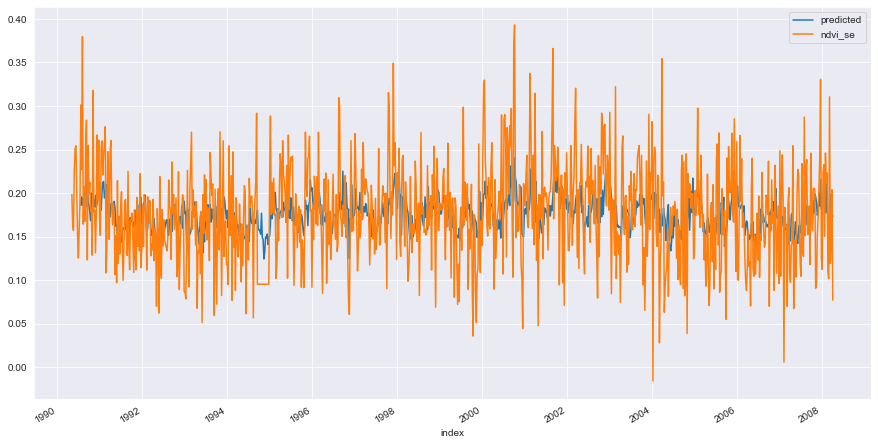

In [65]:
plt.plot(data.index[11:], pred_ndvi_se, label = 'predicted')
data['ndvi_se'].plot(label = 'ndvi_se')
plt.legend()
plt.show()

In [66]:
r2 = r2_score(data['ndvi_se'][11:], pred_ndvi_se)
mae = mean_absolute_error(data['ndvi_se'][11:],pred_ndvi_se)
mse = mean_squared_error(data['ndvi_se'][11:], pred_ndvi_se)
print('model: {} \n r2-score: {} \n mae: {} \n mse: {}'.format('ndvi_se', r2, mae, mse))

model: ndvi_se 
 r2-score: 0.09745051559818119 
 mae: 0.04338507917787456 
 mse: 0.0030059227524592046


### Building a linear dynamic model for data reanalysis_relative_humidity_percent

In [67]:
# creating a dataframe
data_reanalysis_relative_humidity_percent = data[['reanalysis_relative_humidity_percent','station_avg_temp_c','station_precip_mm']]
data_reanalysis_relative_humidity_percent.head()

,reanalysis_relative_humidity_percent,station_avg_temp_c,station_precip_mm
index,,,
1990-05-06,73.365714,25.442857,16.0
1990-05-13,77.368571,26.714286,8.6
1990-05-20,82.052857,26.714286,41.4
1990-05-27,80.337143,27.471429,4.0
1990-06-03,80.460000,28.942857,5.8


In [68]:
model = VAR(data_reanalysis_relative_humidity_percent, freq="1W")
model.select_order(20).summary()


,AIC,BIC,FPE,HQIC
0,9.452,9.468,1.273e+04,9.458
1,7.585,7.649,1969.,7.610
2,7.508,7.618*,1822.,7.550*
3,7.504,7.662,1816.,7.565
4,7.489,7.694,1789.,7.568
5,7.478,7.730,1768.,7.574
6,7.466,7.766,1748.,7.581
7,7.448,7.795,1716.,7.580
8,7.436,7.831,1696.,7.587
9,7.442,7.884,1706.,7.611


In [69]:
results = model.fit(14)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, Apr, 2021
Time:                     20:50:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    8.08891
Nobs:                     922.000    HQIC:                   7.67128
Log likelihood:          -7213.46    FPE:                    1658.75
AIC:                      7.41362    Det(Omega_mle):         1446.74
--------------------------------------------------------------------
Results for equation reanalysis_relative_humidity_percent
                                              coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------
const                                           15.375384         4.158059            3.698           0.000
L1.reanalysis_relative_humidi

In [73]:
df_reanalysis_relative_humidity_percent_full = lag_df(data_reanalysis_relative_humidity_percent, 14, 3)
df_reanalysis_relative_humidity_percent_full.dropna(inplace = True)
df_reanalysis_relative_humidity_percent_full.head()

,reanalysis_relative_humidity_percent,station_avg_temp_c,station_precip_mm,reanalysis_relative_humidity_percent_shift_1,station_avg_temp_c_shift_1,station_precip_mm_shift_1,reanalysis_relative_humidity_percent_shift_2,station_avg_temp_c_shift_2,station_precip_mm_shift_2,reanalysis_relative_humidity_percent_shift_3,...,station_precip_mm_shift_11,reanalysis_relative_humidity_percent_shift_12,station_avg_temp_c_shift_12,station_precip_mm_shift_12,reanalysis_relative_humidity_percent_shift_13,station_avg_temp_c_shift_13,station_precip_mm_shift_13,reanalysis_relative_humidity_percent_shift_14,station_avg_temp_c_shift_14,station_precip_mm_shift_14
index,,,,,,,,,,,,,,,,,,,,,
1990-08-12,79.650000,28.200000,11.4,80.584286,28.242857,37.6,80.742857,28.114286,32.6,82.144286,...,4.0,82.052857,26.714286,41.4,77.368571,26.714286,8.6,73.365714,25.442857,16.0
1990-08-19,84.178571,28.042857,44.7,79.650000,28.200000,11.4,80.584286,28.242857,37.6,80.742857,...,5.8,80.337143,27.471429,4.0,82.052857,26.714286,41.4,77.368571,26.714286,8.6
1990-08-26,80.947143,28.342857,5.4,84.178571,28.042857,44.7,79.650000,28.200000,11.4,80.584286,...,39.1,80.460000,28.942857,5.8,80.337143,27.471429,4.0,82.052857,26.714286,41.4
1990-09-02,83.348571,28.657143,13.7,80.947143,28.342857,5.4,84.178571,28.042857,44.7,79.650000,...,29.7,79.891429,28.114286,39.1,80.460000,28.942857,5.8,80.337143,27.471429,4.0
1990-09-09,77.172857,28.328571,14.2,83.348571,28.657143,13.7,80.947143,28.342857,5.4,84.178571,...,21.1,82.000000,27.414286,29.7,79.891429,28.114286,39.1,80.460000,28.942857,5.8


In [74]:
pred_reanalysis_relative_humidity_percent = np.dot(df_reanalysis_relative_humidity_percent_full.drop(['reanalysis_relative_humidity_percent', 'station_avg_temp_c', 'station_precip_mm'], axis = 1 ).values,\
       results.params['reanalysis_relative_humidity_percent'][1:].values ) + results.params['reanalysis_relative_humidity_percent'][0]

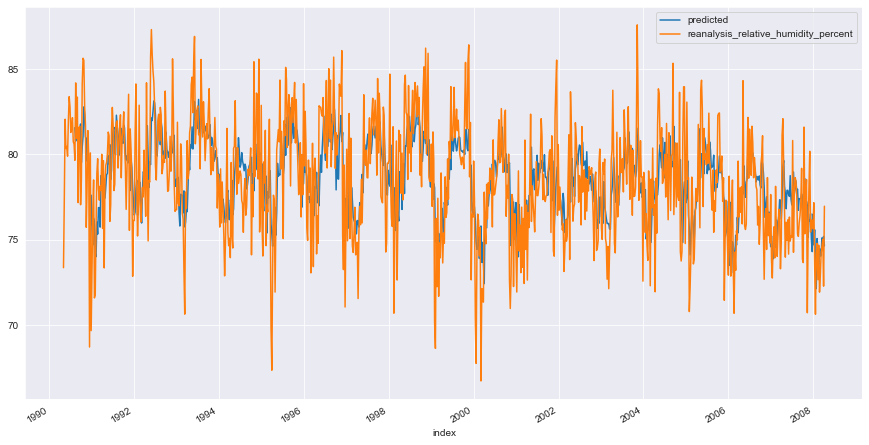

In [75]:
plt.plot(data.index[14:], pred_reanalysis_relative_humidity_percent, label = 'predicted')
data['reanalysis_relative_humidity_percent'].plot(label = 'reanalysis_relative_humidity_percent')
plt.legend()
plt.show()

In [77]:
r2 = r2_score(data['reanalysis_relative_humidity_percent'][14:], pred_reanalysis_relative_humidity_percent)
mae = mean_absolute_error(data['reanalysis_relative_humidity_percent'][14:],pred_reanalysis_relative_humidity_percent)
mse = mean_squared_error(data['reanalysis_relative_humidity_percent'][14:], pred_reanalysis_relative_humidity_percent)
print('model: {} \n r2-score: {} \n mae: {} \n mse: {}'.format('pred_reanalysis_relative_humidity_percent', r2, mae, mse))

model: pred_reanalysis_relative_humidity_percent 
 r2-score: 0.3839146881200224 
 mae: 2.090991801835686 
 mse: 7.064469340931801


## From the obtained scores, it is clear that Linear dynamic models are better than auto regression models.